# Classification pt IIa - Logistic Regression and higher order decision boundaries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from math import *
from nltk.corpus import stopwords
from nltk import download
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import re
import nltk
from collections import Counter

%matplotlib inline

plt.style.use('fivethirtyeight')

So far, we've been using logistic regression in terms of linear regression.  There is also a class in scikit-learn called `LogisticRegression`.  In order to fit it, it's using methods totally different than what we've used so far.  The method it uses involves defining a _cost function_, which you take the _derivative_ of and then perform some kind of _gradient-based optimization_.  Don't worry if that confuses you; we won't be dealing with any of that stuff in this term.

There is one extra thing that's going on under the hood though, and that's __regularization__.  We'll discuss that on Friday, as well as the notion of _parameters_ and _hyperparameters_.

You'll notice that this lab is `IIa`, because I need some time to consolodate all your collections of tweets into a single datafile.  We'll get to that as soon as I can!  For now, we have some practice thta will warm us up to it.

## 0: Differences in linear and logistic regression scikit-learn models

<div style="color:red"> Look through the documentation, or use the method we did when inspecting the `LinearRegression` model in scikit-learn, to determine the similarities and differences in possible keyword arguments between scikit-learn objects `LinearRegression` and `LogisticRegression`.  Tell me which ones are shared, what they are, and which are different, and what _they_ are.</div>

In [3]:
print([i for i in dir(LogisticRegression) if i in dir(LinearRegression) and not i.startswith("_")]) #shared
print([i for i in dir(LinearRegression) if i not in dir(LogisticRegression) and not i.startswith("_")]) #linear
print([i for i in dir(LogisticRegression) if i not in dir(LinearRegression) and not i.startswith("_")]) #logistic

['decision_function', 'fit', 'get_params', 'predict', 'score', 'set_params']
['residues_']
['densify', 'fit_transform', 'predict_log_proba', 'predict_proba', 'sparsify', 'transform']


Both have functions to run the fit on a set of data, make predictions, set decision boundaries and determine an R2 value or an accuracy score. However, LogisticRegression has functions and keyword arguments that allow regularization as well as other tools to manipulate the data.

## 1: Exercises in decision boundaries

<div style="color:red"> For each of the following datasets, train a logistic regression classifier which can classify these points with reasonable accuracy.  </div>

By reasonable here, that you should plot the decision boundary in scatterplot and make a convincing argument that you have accuractly fit the data.  Some thoughts on your process: you should probably

1. Make a scatter plot, discuss what features you probably need and why,
1. Perform whatever feature engineering you think you may need,
1. Train a `LogisticRegression` classifier,
1. Plot a new scatterplot including your decision boundary, and
1. Repeat these steps until you have a good fit.

The datasets are taken from `classification_exercises.csv` in the datasets folder on Canvas, and there are 5 datasets: `a`, `b`, `c`, `bonus`, and `otherbonus`.  The last two are bonuses, but they are not for extra points. They are simply challenge problems!

In [4]:
df = pd.read_csv('data/classification_exercises.csv', index_col=0)
df.head()

,x_a1,x_a2,y_a,X_b1,X_b2,y_b,X_c1,X_c2,y_c,X_bonus1,X_bonus2,y_bonus,X_otherbonus1,X_otherbonus2,y_otherbonus
0,-1.211120,-1.298578,0,0.875489,0.000982,1,0.712428,-0.543703,1,2.400049,0.000982,1,-0.336619,-0.511577,1
1,-0.302356,-0.383873,0,-0.535927,-0.694028,1,0.100214,0.123386,1,0.585127,-0.694028,1,0.511056,-0.667005,0
2,0.292731,1.125287,1,0.884205,-0.655863,0,0.968032,-0.695576,1,2.421059,-0.655863,0,0.654773,-0.418236,0
3,1.507676,1.363869,1,-0.096443,-0.934155,0,1.456700,-0.710133,1,0.908062,-0.934155,0,-0.507675,-0.285552,1
4,-0.646882,2.775098,1,-1.008296,0.188571,0,0.362917,0.763035,1,0.364840,0.188571,0,0.063443,0.782734,0


Above I import the data and below I make scatter plots for each dataset to help with feature engineering.

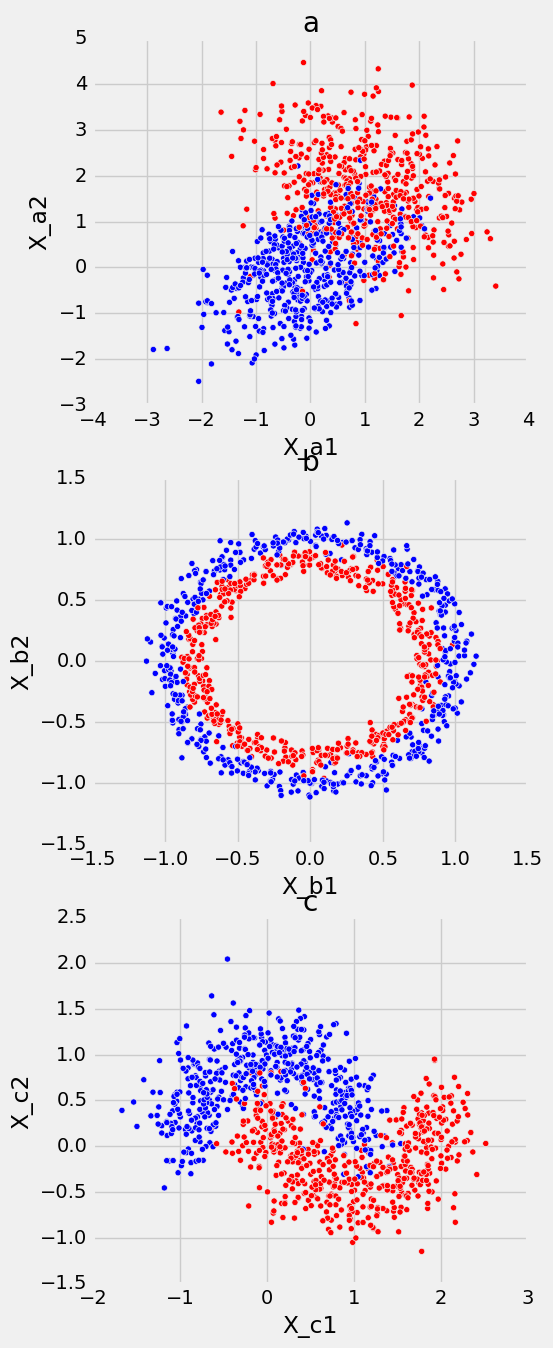

In [5]:
dfa = df[["x_a1","x_a2","y_a"]]
dfa.columns = ["X_a1","X_a2","y_a"]
dfb = df[["X_b1","X_b2","y_b"]]
dfc = df[["X_c1","X_c2","y_c"]]

fig = plt.figure(figsize=(5,15))
ascat = fig.add_subplot(3,1,1)
bscat = fig.add_subplot(3,1,2)
cscat = fig.add_subplot(3,1,3)

colorings = lambda val: 'b' if val is 0 else 'r'

ascat.scatter(dfa["X_a1"],dfa["X_a2"], c=dfa['y_a'].map(colorings))
ascat.set_title('a')
ascat.set_xlabel('X_a1')
ascat.set_ylabel('X_a2')

bscat.scatter(dfb["X_b1"],dfb["X_b2"], c=dfb['y_b'].map(colorings))
bscat.set_title('b')
bscat.set_xlabel('X_b1')
bscat.set_ylabel('X_b2')

cscat.scatter(dfc["X_c1"],dfc["X_c2"], c=dfc['y_c'].map(colorings))
cscat.set_title('c')
cscat.set_xlabel('X_c1')
cscat.set_ylabel('X_c2')

plt.show()

So, it looks like model a needs to be linear, model b is clearly a circle, and model c is either a third-order polynomial or sinusoidal. Below I make a decision boundary for each model and calculate its accuracy score.

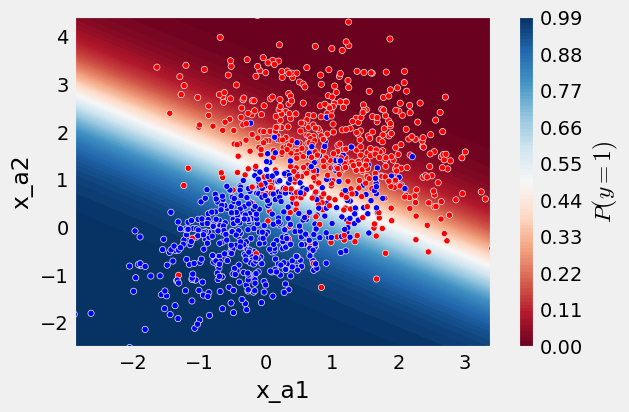

0.84899999999999998

In [6]:
#### SET THESE ####
# This should be an (n x p) numpy ndarray, consisting of your data.  This
# will NOT create your scatter plot, you'll need to do that yourself.
X_data = df[['x_a1', 'x_a2']].values        # This is an example!

x_axis_name = 'x_a1'
y_axis_name = 'x_a2'

model = LogisticRegression()
model.fit(X_data, df["y_a"])

# CONSTANTS
GRANULARITY = 50

# Create a mesh
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

# In order to produce the prediction values, we `ravel` the xx's and yy's.
# This means we turn the grid of values into a single column, which we later `reshape`.
xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

########################################## SADLY, YOU NEED TO DO THIS ##########################################
# This matrix needs to consist of exactly what your X matrix consisted of, where "xx1_col" replaces `x_1`,
# and "xx2_col" replaces "x_2".
X_columns = np.c_[xx1_col, xx2_col] #xx1_col**2,

#### PLOTTING ####
yy = model.predict_proba(X_columns).T[0]
yy = yy.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure() # You can set `figsize` here if you want
ax = figure.add_subplot(1,1,1)
# Set plot limits
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.set_xlabel('x_a1')
ax.set_ylabel('x_a2')

## Uncomment whichever of these you want: ##
# Just the decision boundary, where:
#     - `levels` is what determines the actual value (or values) of the boundary, and
#     - `colors` is the color of each level above

#ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])

# The entire decision surface, where:
#     - `100`  refers to the number of contours to plot, set it to more for a smoother look
#     - `cmap` is the colormap we're using.  Options: http://matplotlib.org/users/colormaps.html
#     - `vmin` and `vmax` are the low and high output values to plot

contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
ax_c.set_label("$P(y = 1)$") # Labels the above colorbar

# Add your scatter plot here:
ax.scatter(df[x_axis_name],df[y_axis_name], c=df['y_a'].map(colorings))  # set c= to color your points based on their `y` value

plt.show()

model.score(X_data, df["y_a"])

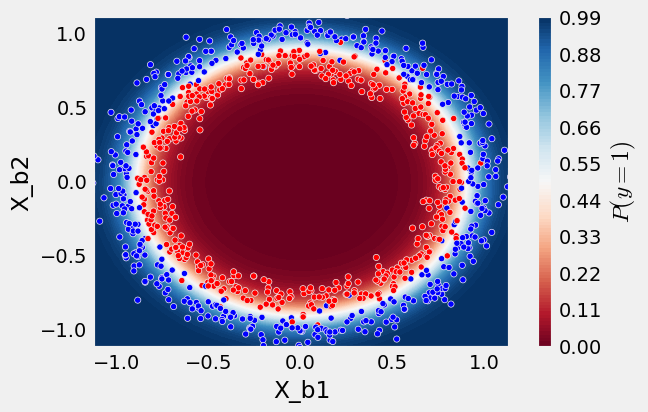

0.95299999999999996

In [7]:
df["x_circ1"] = df["X_b1"]**2
df["x_circ2"] = df["X_b2"]**2
#### SET THESE ####
# This should be an (n x p) numpy ndarray, consisting of your data.  This
# will NOT create your scatter plot, you'll need to do that yourself.
X_data = df[['X_b1', 'X_b2', "x_circ1", "x_circ2"]].values        # This is an example!

x_axis_name = 'X_b1'
y_axis_name = 'X_b2'

model = LogisticRegression()
model.fit(X_data, df["y_b"])

# CONSTANTS
GRANULARITY = 50

# Create a mesh
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

# In order to produce the prediction values, we `ravel` the xx's and yy's.
# This means we turn the grid of values into a single column, which we later `reshape`.
xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

########################################## SADLY, YOU NEED TO DO THIS ##########################################
# This matrix needs to consist of exactly what your X matrix consisted of, where "xx1_col" replaces `x_1`,
# and "xx2_col" replaces "x_2".
X_columns = np.c_[xx1_col, xx2_col, xx1_col**2, xx2_col**2] 

#### PLOTTING ####
yy = model.predict_proba(X_columns).T[0]
yy = yy.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure() # You can set `figsize` here if you want
ax = figure.add_subplot(1,1,1)
# Set plot limits
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.set_xlabel('X_b1')
ax.set_ylabel('X_b2')

## Uncomment whichever of these you want: ##
# Just the decision boundary, where:
#     - `levels` is what determines the actual value (or values) of the boundary, and
#     - `colors` is the color of each level above

#ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])

# The entire decision surface, where:
#     - `100`  refers to the number of contours to plot, set it to more for a smoother look
#     - `cmap` is the colormap we're using.  Options: http://matplotlib.org/users/colormaps.html
#     - `vmin` and `vmax` are the low and high output values to plot

contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
ax_c.set_label("$P(y = 1)$") # Labels the above colorbar

# Add your scatter plot here:
ax.scatter(df[x_axis_name],df[y_axis_name], c=df['y_b'].map(colorings))  # set c= to color your points based on their `y` value

plt.show()

model.score(X_data, df["y_b"])

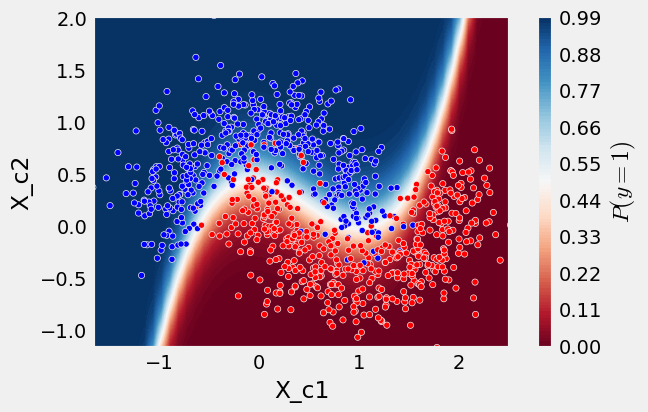

0.95299999999999996

In [9]:
df["x_tri"] = df["X_c1"]**3
df["x_bi"] = df["X_c1"]**2

#### SET THESE ####
# This should be an (n x p) numpy ndarray, consisting of your data.  This
# will NOT create your scatter plot, you'll need to do that yourself.
X_data = df[['X_c1', 'X_c2', "x_bi", "x_tri"]].values        # This is an example!

x_axis_name = 'X_c1'
y_axis_name = 'X_c2'

model = LogisticRegression()
model.fit(X_data, df["y_c"])

# CONSTANTS
GRANULARITY = 50

# Create a mesh
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

# In order to produce the prediction values, we `ravel` the xx's and yy's.
# This means we turn the grid of values into a single column, which we later `reshape`.
xx1_col = xx1.ravel()
xx2_col = xx2.ravel()

########################################## SADLY, YOU NEED TO DO THIS ##########################################
# This matrix needs to consist of exactly what your X matrix consisted of, where "xx1_col" replaces `x_1`,
# and "xx2_col" replaces "x_2".
X_columns = np.c_[xx1_col, xx2_col, xx1_col**2, xx1_col**3]
#### PLOTTING ####
yy = model.predict_proba(X_columns).T[0]
yy = yy.reshape(xx1.shape)

#### PLOTTING ####

figure = plt.figure() # You can set `figsize` here if you want
ax = figure.add_subplot(1,1,1)
# Set plot limits
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.set_xlabel('X_c1')
ax.set_ylabel('X_c2')

## Uncomment whichever of these you want: ##
# Just the decision boundary, where:
#     - `levels` is what determines the actual value (or values) of the boundary, and
#     - `colors` is the color of each level above

#ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])

# The entire decision surface, where:
#     - `100`  refers to the number of contours to plot, set it to more for a smoother look
#     - `cmap` is the colormap we're using.  Options: http://matplotlib.org/users/colormaps.html
#     - `vmin` and `vmax` are the low and high output values to plot

contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour) # Adds a colorbar, which is like a continuous legend
ax_c.set_label("$P(y = 1)$") # Labels the above colorbar

# Add your scatter plot here:
ax.scatter(df[x_axis_name],df[y_axis_name], c=df['y_c'].map(colorings))  # set c= to color your points based on their `y` value

plt.show()

model.score(X_data, df["y_c"])

I believe these models to be accurate. The accuracy score for models b and c are >95% while the accuracy for model a is 85% (this is expected as there is quite a bit of overlap between the two classifcations).

## Naive Bayes

You know what I hate about Fall?  I hate how early all the Christmas music comes out.  Why does it feel like it comes out earlier and earlier every year?  Let's make a classifier that can distinguish between lines of Christmas music lyrics, and the only thing I'm allowed to listen to these days: children's music lyrics.

We'll try to perform this classification with a new type of classifier, Naive Bayes.  In the Naive Bayes classifier, the goal is the same, but the process is completely different.  Why might you care about this?  The reason is the __assumptions__ of the model.  For example, the assumptions of linear regression are:

* Linear relationship: Hopefully this one is obvious.  The predictors should be linearly related to the response (perhaps after feature engineering)
* Multivariate normality: the predictors are taken from a multivariate normal distribution (often not true, but not a huge issue)
* No or little multicollinearity: essentially, a generalization of what it would mean for a non-square matrix to have a non-zero determinant.  This is not a good explanation, and it isn't quite true, but this is also a bit of a technicality that we shouldn't concern ourselves with.
* No auto-correlation in the errors: We've discussed this one!
* Homoscedasticity: If you happen to have different response variables (we never have), then they have the same variance.

<div style="color:red"> To start, do some searching around online to see if you can determine what the assumptions of Logistic Regression and Naive Bayes are. Why might Naive Bayes be a good choice for analyzing lines of song lyrics?</div>

Naive Bayes assumes that each feature is independent of one another, which is rarely actually the case in natural language. But, the algorithm is designed to be used with all binary features (such as the presence of a word) while logistic regression is not.

#### What is Naive Bayes?

Before we answer that, we need to establish some terminology: in this setting, a __document__ is a single line of lyrics, and the __corpus__ is the total collection of all lyrics.

Based on the assumptions you determined above, there is a somewhat-standard-but-too-much-probability-for-me-today derivation of the Naive Bayes algorithm.  What you arrive at is the very believable equation:

$$p\left(C_k \mid x_1, \ldots, x_n\right) = \frac{1}{Z}\ p\left(C_k\right)\prod_{i=1}^n p\left(x_i \mid C_k\right)$$

("Doesn't look very believable to me," you could rightly say.) This is far easier to understand than it looks.  What are all the pieces of this equation?

* $p\left(C_k \mid x_1, \ldots, x_n\right)$ is the __conditional probability__ of the vector $\overline{v} = \left<x_1, \ldots, x_n\right>$ being in class $C_k$.  More simply, it's the chance that the document you're currently looking at is in the class you're currently considering it to be in.  You compute this probability for all the classes, and then just choose the largest-probability class for $\overline{v}$.
* $\frac{1}{Z}$ is a scaling factor used to make everything add up to 1, because probabilities always have to add to one.  Since it doesn't depend on the class, it's of no interest to us. (If you had to pick the bigger of two things: $y = 2x$ and $z = 3x$, for some positive number x, you don't care what $x$ is, you know $z$ is automatically the winner. So you can just ignore the $x$.)
* $p\left(C_k\right)$ is the __prior probability__ of class $C_k$.  This is a way fancier name than it needs to be: it's the fraction of total documents that are in class $C_k$.
* $\prod_{i=1}^n$ is the __product__ symbol.  Just like $\sum_{i=1}^n$ is the sum symbol.  It just means "multiple up all the following:".
* $p\left(x_i \mid C_k\right)$ is the __likelihood__ of $x_i$ being in class $C_k$.  Again, it's just a fraction: it's the fraction of those documents in class $C_k$ which actually contain $x_i$.  If there are 5 tweets that are classified as "hangry", and 2 of them contain the word "eat", then the likelihood $p\left(\text{"eat"} \mid \text{"hangry"}\right) = \frac{2}{5}$. It doesn't matter for this calculation that there were also 3 occurances of "eat" that were classified as "not hangry", or that the "not hangry" class had 25 tweets it in.

So, putting this all together, you need to calculate all the $p\left(C_k\right)$ terms for each class, and the $\prod_{i=1}^n p\left(x_i \mid C_k\right)$ terms for each (document, class) pair, and then given any document, you classify a document (for training or for new, test data) by computing all the conditional probabilities for each class and picking the class with the highest probability.  

#### Okay, so: your turn.  
<div style="color:red"> Make a Naive Bayes classifier on your dataset of "lines from songs", classifying them as children's music or Christmas music.</div>

The datasets should be taken from `christmas_music.txt` and `non_christmas_music.txt` on Canvas.

Here's a potentially incomplete list of tasks to do:
* read in the text files,
* clean them up appropriately (for example in song lyrics, some words have shortenings like `e'erywhere` or `singin'` that you should probably expand before stemming),
* vectorize/stem the words, remove stopwords,
* (you may need to build a special stopword list over time: filter out your current list of stop words, view the words that are in a ton of documents, add those your list of stop words, filter again, etc.)
* create a bunch of counts of the "total collection of documents", "total collection of documents in class 1 (Christmas)", "total collection of documents in class 0 (Children's)",
* create two global variables: the first is `CORPUS_SIZE`, its the number of words to include from your _corpus_, or body of documents.  The second is below: `BIGRAM_MULTIPLIER`.
* <span style="color:red"> Once you successfully do create the model, do the same thing again inluding the top `BIGRAM_MULTIPLIER * CORPUS_SIZE` bigrams in your corpus.  Bigrams are pairs of words in succession.</span>

#### Note: this may look disturbingly similar to what we're going to do on the tweet dataset!  That's the point!  This is practice for that, and a lot of the code you right should carry over just fine.

#### Note 2: A lot of the above can be done using `nltk`.  Use it! This lab would be way too long without using that library.

Here I get a prepared corpus (a list where each item is a list of stemmed words for each document)

In [14]:
stopwords_list = stopwords.words('english') + ["let", "1", "2", "3", "4", "5", "6", "7", "8", "9", "one", "two"]

#so elegant (i <3 nltk)
#this basically is the first lab in like 6 lines
stemmer = PorterStemmer() #initialize stemmer
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') #initialize tokenizer

def preprocess(string):
    tokens = tokenizer.tokenize(string.lower()) #tokenize, make lowercase, create list
    filtered_words = [stemmer.stem(w) for w in tokens if not w in stopwords_list] #remove stopwords
    return filtered_words

with open("data/christmas_music.txt", "r", encoding="utf-8") as corpus_text:
    xmas = [i for i in [preprocess(line) for line in corpus_text.readlines()] if len(i)>0]
with open("data/non_christmas_music.txt", "r", encoding="utf-8") as corpus_text:
    nonxmas = [i for i in [preprocess(line) for line in corpus_text.readlines()] if len(i)>0]

Python magic i.e. make set for each document (each word only appears once per document now) and make master list for each corpus

In [15]:
xmas_word_list = []
xmas_ngram_list = []
for document in xmas:
    xmas_word_list += set(document)
    xmas_ngram_list += set(ngrams(document, 2))

nonxmas_word_list = []
nonxmas_ngram_list = []
for document in nonxmas:
    nonxmas_word_list += set(document)
    nonxmas_ngram_list += set(ngrams(document, 2))

Now we can easily make a counter which tells us how many documents each word shows up in

In [16]:
count_xmas = Counter(xmas_word_list)
count_xmas2 = Counter(xmas_ngram_list)
count_nonxmas = Counter(nonxmas_word_list)
count_nonxmas2 = Counter(nonxmas_ngram_list)

Now, I make a dictionary of probabilites for each common christmas word or bigram. 4 total. Also I have a function to classify the input sentence.

In [17]:
CORPUS_SIZE = 100
BIGRAM_MULTIPLIER = 2

xlen = len(xmas)
nxlen = len(nonxmas)
total_len = xlen + nxlen

#NB classification
pc1 = xlen/total_len
pc0 = nxlen/total_len

#dictionaries of probabilities (add 1 to avoid 0s)
common1 = {w: (p+1)/xlen for w,p in count_xmas.most_common(CORPUS_SIZE)}
common0 = {w: (count_nonxmas[w]+1)/nxlen for w,p in count_xmas.most_common(CORPUS_SIZE)}
common1_bi = {w: (p+1)/xlen for w,p in count_xmas2.most_common(CORPUS_SIZE*BIGRAM_MULTIPLIER)}
common0_bi = {w: (count_nonxmas2[w]+1)/nxlen for w,p in count_xmas2.most_common(CORPUS_SIZE*BIGRAM_MULTIPLIER)}
 
def naive_bayes(pc, common, document):
    prob = 1 * pc
    for w in document:
        if w in list(common.keys()):
            prob *= common[w]
    return prob

def nb_classify(pc_true, pc_false, common_true, common_false, doc, bi=False):
    if bi:
        doc = list(ngrams(doc,2))
    if naive_bayes(pc_true, common_true, doc) > naive_bayes(pc_false, common_false, doc):
        return True
    else:
        return False

#test case
test = ["come","santa","babi","lord","sing"]
print(nb_classify(pc1,pc0,common1,common0,test)) #by words
print(nb_classify(pc1,pc0,common1_bi,common0_bi,test,bi=True)) #by bigrams

True
True
